From https://www.tensorflow.org/tutorials/generative/autoencoder

In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

from tensorflow.keras.datasets import fashion_mnist

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

Load the dataset

In [5]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# Additional conversion to fix the type changes after added noise
x_train = tf.convert_to_tensor(x_train, np.float32)
x_test = tf.convert_to_tensor(x_test, np.float32)

In [7]:
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [8]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


Add random noise to images

In [9]:
noise_factor = 0.2

In [10]:
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

In [11]:
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.0)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.0)

Plot the noisy images

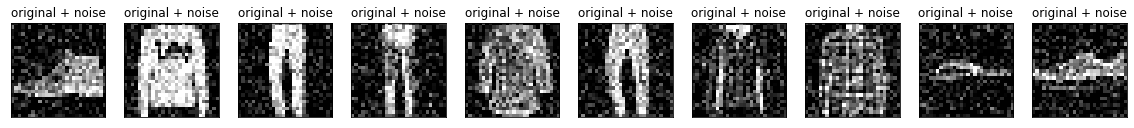

In [12]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("original + noise")
plt.show()

Convolutional Autoencoder

In [13]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
            layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)
        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')
        ])
            
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [14]:
autoencoder = Denoise()

In [15]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [16]:
autoencoder.fit(x_train_noisy, x_train, epochs=10, shuffle=True, validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 56s 926us/sample - loss: 0.0163 - val_loss: 0.0097
Epoch 2/10
60000/60000 [==============================] - 57s 948us/sample - loss: 0.0090 - val_loss: 0.0085
Epoch 3/10
60000/60000 [==============================] - 73s 1ms/sample - loss: 0.0082 - val_loss: 0.0081
Epoch 4/10
60000/60000 [==============================] - 77s 1ms/sample - loss: 0.0078 - val_loss: 0.0078
Epoch 5/10
60000/60000 [==============================] - 78s 1ms/sample - loss: 0.0076 - val_loss: 0.0076
Epoch 6/10
60000/60000 [==============================] - 77s 1ms/sample - loss: 0.0075 - val_loss: 0.0074
Epoch 7/10
60000/60000 [==============================] - 79s 1ms/sample - loss: 0.0073 - val_loss: 0.0073
Epoch 8/10
60000/60000 [==============================] - 77s 1ms/sample - loss: 0.0072 - val_loss: 0.0073
Epoch 9/10
60000/60000 [==============================] - 71s 1ms/sample - loss: 0.0072 - 

In [17]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [18]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran multiple                  584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr multiple                  1168      
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [19]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

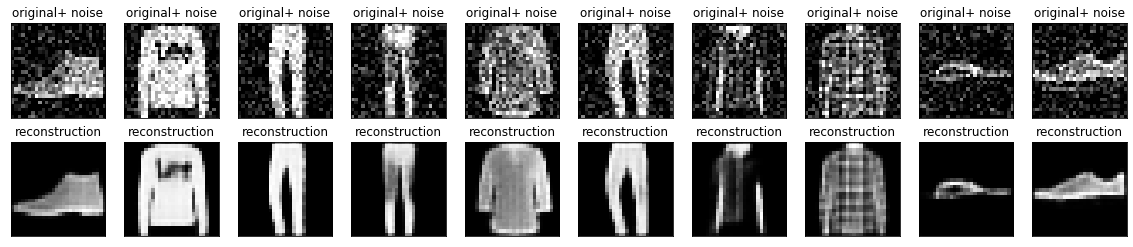

In [20]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("original+ noise")
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title("reconstruction")
plt.show()